---
title: "Notebook to establish mini-batch training from first principles"
author: "John Richmond"
format:
  html:
    code-fold: False
  pdf:
    geometry:
      - top=30mm
      - left=20mm
jupyter: python3
toc: true
number-sections: False
shift-heading-level-by: -1
---

<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

## Introduction

Notebook based upon the fastai course 22p, "Part 2 of Practical Deep Learning for Coders".  This notebook builds the capability for training a model in batches.  As such it covers:
* understanding managing and accessing model parameters
* Cross entropy loss for classification
* dataloaders, including samplers and multiprocessing
* optimisers - implementation of SGD and how to implement using model parameters
* setting up training loops with validation


In [ ]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

path_to_data = Path('/Users/johnrichmond/local_datasets') / Path('data')
path_to_data.mkdir(exist_ok=True)
path_gz = path_to_data / 'mnist.pkg.gz'

with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

## Initial setup

### Data
As before use Mnist data with a single hidden layer of 50 neurons

In [2]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50
n, m, c

(50000, 784, tensor(10))

Create a simple model that inherits from the pytorch nn.Module class

In [3]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

Pass the training data though the model and store the predictions.  Check the shape of the output and also what the range of the preds is

In [4]:
model = Model(n_in=m, nh=nh, n_out=c)
preds = model(x_train.clone())
preds.shape, preds.min(), preds.max()

(torch.Size([50000, 10]),
 tensor(-0.35, grad_fn=<MinBackward1>),
 tensor(0.42, grad_fn=<MaxBackward1>))

## Loss Function

In the previous notebook a very simple loss function was used.  This will now be replaced with a cross entropy loss.  There are several "tricks" that are used to take what is basically a relatively simple concept and implement it in a robust and efficient fashion.  These will be explained.

$$\hbox{softmax(x)}_{i} = \frac{e^{x{_i}}}{e^{x{_1}}+e^{x{_2}} + \cdots + e^{x{_n}}}$$

Or:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum\limits_{0 \leq j < n}{e^{x_{j}}}}$$

In [113]:
# Note that this relies upon broadcasting the sum along axis 1 to make the divide work
def log_softmax(x): return (x.exp() / (x.exp().sum(axis=-1, keepdim=True))).log()

In [6]:
log_softmax(preds)

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<LogBackward0>)

Since the log of a division is the same as subtracting the logs of each value this can be further simplified

In [7]:
def log_softmax(x): return (x - (x.exp().sum(axis=-1, keepdim=True)).log())

In [8]:
log_softmax(preds)

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<SubBackward0>)

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

Where a is the maximum of the $x_j$ values, and is used to scale other values, preventing numerical overflow

In [9]:
x = preds.clone()
x.shape

torch.Size([50000, 10])

In [10]:
def logsumexp(x):
    # obtain the maximum x in each input row
    max_row_vals = x.max(axis=-1)[0]
    return (max_row_vals + (x - max_row_vals[:, None]).exp().sum(-1).log())

In [11]:
logsumexp(x)

tensor([2.28, 2.30, 2.29,  ..., 2.30, 2.28, 2.30], grad_fn=<AddBackward0>)

Pytorch already has a pre build logsumexp and this can be used instead of the above.  To check the same values are returned:

In [12]:
test_close(logsumexp(x), x.logsumexp(dim=-1, keepdim=False))

Hence it is possible to simplify the above log softmax to

In [13]:
def log_softmax(x):
    return x-x.logsumexp(-1, keepdim=True)

In [14]:
lsm_preds = log_softmax(x)
lsm_preds

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<SubBackward0>)

Having calculated the log softmax we now need a proper loss function.  For classification we can use the cross entropy loss.  This is defined as:

$$ CE Loss = \sum_i{x_i \log{ p(x_i)}}$$

where x is a vector of targets.  Note that in Pytorch this is not one hot encoded and so the value can be used as an index to select the column of the preds that it refers to. 

In this case the softmax can be interpreted as a probability (since it adds up to one for each case) and the output from the log_softmax is $log(p(x_i))$ is a vector for each class.

The CE loss can therefore be obtained by taking the mean of the CE loss over the dataset.  Since x is zero over every element apart from the target, where it is one, this in practice means that all that has to be done is to calculate $-\log{p(x_i)}$ where i is the index of the actual target

Obtaining the index of the target can be done using the target as an index (as discussed above)

In [15]:
y_train.shape, y_train[0:3]

(torch.Size([50000]), tensor([5, 0, 4]))

Since y_train is a vector we can use it to select the column as below.  This could be summed and divided by the number of datapoint but the alternative is used, which is to take the mean

In [16]:
def nll(preds, targets):
    return -preds[range(preds.shape[0]), targets].mean()

In [17]:
loss = nll(lsm_preds, y_train)
loss

tensor(2.30, grad_fn=<NegBackward0>)

Check that the loss value calculate above matches that from Pytorch

In [18]:
test_close(F.nll_loss(F.log_softmax(x, dim=1), y_train), loss, 1.e-3)

In [19]:
test_close(F.cross_entropy(x, y_train), loss, 1.e-3)

We have now generate a loss function from first principles and can use Pytorch's version moving forward

## Development of a training loop

The training loop repeats the following iteratively:
* Load a batch of input data and the corresponding target outputs
* Calculate the predictions from the input data
* Calculate the loss based upon the targets and predictions
* Calculate the gradients with respect to the loss of all of the model parameters
* Update the parameters based upon the gradients so as to reduce the loss

### A simple training loop
Before we train it is convenient to have a way to ascertain the accuracy of the model. To develop this a single batch of data will be processed

In [20]:
bs = 64
# load a minibatch
xb = x_train[0:bs]
yb = y_train[0:bs]
preds = model(xb)
preds.shape, preds[0]

(torch.Size([64, 10]),
 tensor([-0.09, -0.21, -0.08,  0.10, -0.04,  0.08, -0.04, -0.03,  0.01,  0.06], grad_fn=<SelectBackward0>))

In [21]:
# Define a loss function and calculate the loss for the batch
loss_func = F.cross_entropy
loss = loss_func(preds, yb)
loss

tensor(2.30, grad_fn=<NllLossBackward0>)

#### Calculate Accuracy

The predicted class can be determined from the index of the class having the highest predicted value

In [22]:
pred_class = torch.argmax(preds, axis=1)
pred_class

tensor([3, 9, 3, 8, 5, 9, 3, 9, 3, 9, 5, 3, 9, 9, 3, 9, 9, 5, 8, 7, 9, 5, 3, 8, 9, 5, 9, 5, 5, 9, 3, 5, 9, 7, 5, 7, 9, 9, 3, 9, 3, 5, 3, 8,
        3, 5, 9, 5, 9, 5, 3, 9, 3, 8, 9, 5, 9, 5, 9, 5, 8, 8, 9, 8])

From this the accuracy can be calculated

In [1]:
#| echo: false
#| output: asis
show_doc(accuracy)

---

[source](https://github.com/fastai/fastai-course-22p/blob/master/miniai/training.py#L13){target="_blank" style="float:right; font-size:smaller"}

### accuracy

>      accuracy (preds, targets)

In [24]:
accuracy(preds, yb)

tensor(0.09)

Not suprisingly, at this point the accuracy is what would be expected for a random prediction.

To improve this we need to train the model.  To do that it is necessary to say what learning rate we would like and how many epochs to train for

In [25]:
lr = 0.5
epochs = 3

Now create a simple training loop following the above steps. Note that the loss, backward and parameter update is happening for every batch

In [26]:
for epoch in range(epochs):
    # iterate through batches
    for batch in range(0, n, bs):
        # get data
        s = slice(batch, min(n, batch+bs))
        xs = x_train[s]
        ys = y_train[s]
        # Pass data through the model
        preds = model(xs)
        # Calculate loss
        loss = loss_func(preds, ys)
        # Calculate the gradients
        loss.backward()
        # Print the loss periodically
        if batch // bs // 10 == 0: print(f"Loss: {loss.item()}, accuracy = {accuracy(preds, ys).item()}")
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, "weight"):
                    l.weight -= l.weight.grad * lr
                    l.bias -= l.bias.grad * lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()

Loss: 2.3036487102508545, accuracy = 0.09375
Loss: 2.2052316665649414, accuracy = 0.296875
Loss: 2.1905035972595215, accuracy = 0.21875
Loss: 2.010064125061035, accuracy = 0.53125
Loss: 1.9125093221664429, accuracy = 0.5
Loss: 1.7081104516983032, accuracy = 0.703125
Loss: 1.6426200866699219, accuracy = 0.5
Loss: 1.6326062679290771, accuracy = 0.625
Loss: 1.5491729974746704, accuracy = 0.4375
Loss: 1.5245637893676758, accuracy = 0.53125
Loss: 0.12374816089868546, accuracy = 0.96875
Loss: 0.14763614535331726, accuracy = 0.984375
Loss: 0.29614493250846863, accuracy = 0.890625
Loss: 0.16717804968357086, accuracy = 0.9375
Loss: 0.1868995726108551, accuracy = 0.90625
Loss: 0.05588085949420929, accuracy = 0.984375
Loss: 0.10521863400936127, accuracy = 0.96875
Loss: 0.2990257740020752, accuracy = 0.9375
Loss: 0.04911200702190399, accuracy = 1.0
Loss: 0.25950485467910767, accuracy = 0.9375
Loss: 0.09232573211193085, accuracy = 0.96875
Loss: 0.10159078985452652, accuracy = 0.984375
Loss: 0.28459

### Adding parameters and optim

The above training loop works but accessing the model parameters us cumbersome since it requires advanced knowledge of the layers.  Pytorch has some methods to allow accessing and modifying layer information in a more straightforward manner

#### Parameters 
Recreate the model with individual layers

In [27]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in,nh)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(nh,n_out)
        
    def __call__(self, x):
        x = self.l2(self.relu(self.l1(x)))
        return x

In [28]:
model = Model(m, nh, c)

Examine the model parameters

In [29]:
for name, layer in model.named_children():
    print(f"Layer: {name}, Parameters: {layer}")

Layer: l1, Parameters: Linear(in_features=784, out_features=50, bias=True)
Layer: relu, Parameters: ReLU()
Layer: l2, Parameters: Linear(in_features=50, out_features=10, bias=True)


The layers can be accessed using the name alone, for example

In [30]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

The layer parameters can also be accessed by the model.parameters property, however, this is an iterator and hence needs to be listed through a loop or creation of a list...

In [31]:
for param in model.parameters():
    print(param.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [32]:
for param in model.parameters():
    print(param[0:2])

tensor([[ 0.04,  0.03, -0.02,  ...,  0.03,  0.03,  0.00],
        [ 0.04,  0.01,  0.03,  ..., -0.01,  0.02,  0.03]], grad_fn=<SliceBackward0>)
tensor([-0.01, -0.01], grad_fn=<SliceBackward0>)
tensor([[-0.05,  0.02,  0.07,  0.09,  0.10,  0.12, -0.13,  0.10, -0.09, -0.08, -0.12, -0.01,  0.07, -0.00,  0.12, -0.03, -0.07, -0.14,
          0.10,  0.13, -0.12,  0.14,  0.12,  0.08, -0.11,  0.03, -0.09,  0.12,  0.01, -0.03,  0.06, -0.00,  0.01, -0.05,  0.11,  0.14,
          0.07,  0.05, -0.09, -0.03, -0.01, -0.01,  0.08,  0.02, -0.09, -0.05,  0.03,  0.13, -0.08,  0.13],
        [ 0.09, -0.04,  0.00,  0.14, -0.13, -0.06,  0.03, -0.09, -0.11,  0.05,  0.04, -0.02, -0.04, -0.03,  0.01, -0.10, -0.03, -0.02,
          0.00,  0.07,  0.10, -0.08, -0.14, -0.02, -0.13, -0.08,  0.07,  0.04, -0.13, -0.13, -0.05,  0.12, -0.08,  0.13,  0.13, -0.10,
          0.06,  0.08, -0.13, -0.08, -0.06, -0.11,  0.07,  0.06,  0.09,  0.04, -0.13,  0.04, -0.10, -0.01]], grad_fn=<SliceBackward0>)
tensor([-0.01, -0.06], gr

Using parameters it is possible to simplify the code to optimise the weights and biases by looping through teh model parameters.  It is also possible to zero all of the model's gradients with a since call:

In [33]:
def fit():
    for epoch in range(epochs):
        # iterate through batches
        for batch in range(0, n, bs):
            # get data
            s = slice(batch, min(n, batch+bs))
            xs = x_train[s]
            ys = y_train[s]
            # Pass data through the model
            preds = model(xs)
            # Calculate loss
            loss = loss_func(preds, ys)
            # Calculate the gradients
            loss.backward()
            # Print the loss periodically
            if batch // bs // 10 == 0: print(f"Loss: {loss.item()}, accuracy = {accuracy(preds, ys).item()}")
            with torch.no_grad():
                for params in model.parameters():
                    params -= params.grad * lr
                model.zero_grad()

In [34]:
fit()

Loss: 2.309434175491333, accuracy = 0.0625
Loss: 2.177271842956543, accuracy = 0.234375
Loss: 2.259394645690918, accuracy = 0.078125
Loss: 2.0509822368621826, accuracy = 0.578125
Loss: 1.9572300910949707, accuracy = 0.34375
Loss: 1.7929021120071411, accuracy = 0.71875
Loss: 1.6334275007247925, accuracy = 0.65625
Loss: 1.5452338457107544, accuracy = 0.625
Loss: 1.507757306098938, accuracy = 0.4375
Loss: 1.6010795831680298, accuracy = 0.484375
Loss: 0.2006874829530716, accuracy = 0.953125
Loss: 0.11892185360193253, accuracy = 0.96875
Loss: 0.2844753861427307, accuracy = 0.90625
Loss: 0.17238563299179077, accuracy = 0.96875
Loss: 0.15464989840984344, accuracy = 0.90625
Loss: 0.04285932332277298, accuracy = 1.0
Loss: 0.12839168310165405, accuracy = 0.96875
Loss: 0.3218374252319336, accuracy = 0.953125
Loss: 0.09430787712335587, accuracy = 0.96875
Loss: 0.3029904365539551, accuracy = 0.953125
Loss: 0.18196934461593628, accuracy = 0.9375
Loss: 0.0731976106762886, accuracy = 0.984375
Loss: 0.

The way that the model parameters are setup is by Pytorch overriding the __setattrib__ method in nn.Module.  The way that this works is as below

In [35]:
class DummyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in,nh)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(nh,n_out)
        
    def __setattr__(self, k,v):
        # Assign the layers to the modules dict before calling the set attribute class.  The parameters are 
        # simply name (k), value (v)
        if not k.startswith("_"):
            self._modules[k] = v
        super().__setattr__(k,v)
            
    def __repr__(self): 
        # Setup so that the official string representation of the class instance is a listing of the module
        return f"{self._modules}"
    
    def parameters(self):
        # Create an iterator to yield all of the model parameters
        for layer in self._modules.values():
            for param in layer.parameters(): yield(param)

In [36]:
dm = DummyModule(m, nh, c)
dm

{'l1': Linear(in_features=784, out_features=50, bias=True), 'relu': ReLU(), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [37]:
for param in dm.parameters():
    print(param.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


This approach won't work as it with lists of layers as things were originally setup. To allow this. to work the layers have to be individually registered

In [38]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]

In [39]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i, layer in enumerate(self.layers):
            self.add_module(f"layer_{i}", layer)
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [40]:
model = Model(layers)

In [41]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [42]:
fit()

Loss: 2.3222596645355225, accuracy = 0.03125
Loss: 2.2330336570739746, accuracy = 0.21875
Loss: 2.222136974334717, accuracy = 0.140625
Loss: 2.079106330871582, accuracy = 0.421875
Loss: 1.958361029624939, accuracy = 0.5625
Loss: 1.7925820350646973, accuracy = 0.625
Loss: 1.675372838973999, accuracy = 0.515625
Loss: 1.6172857284545898, accuracy = 0.609375
Loss: 1.4986895322799683, accuracy = 0.546875
Loss: 1.5764800310134888, accuracy = 0.515625
Loss: 0.16430063545703888, accuracy = 0.953125
Loss: 0.12203794717788696, accuracy = 0.984375
Loss: 0.3307473063468933, accuracy = 0.890625
Loss: 0.21634256839752197, accuracy = 0.921875
Loss: 0.17808055877685547, accuracy = 0.921875
Loss: 0.04548545181751251, accuracy = 0.984375
Loss: 0.13622808456420898, accuracy = 0.96875
Loss: 0.32709184288978577, accuracy = 0.9375
Loss: 0.09109017997980118, accuracy = 0.984375
Loss: 0.27433082461357117, accuracy = 0.953125
Loss: 0.09979915618896484, accuracy = 0.96875
Loss: 0.08315068483352661, accuracy = 0

Registering the layers can be done using the nn.ModuleList class:
[Link to nn.ModuleList docs](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html?highlight=nn+modulelist#torch.nn.ModuleList)

Thus this allows further simplification

In [43]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [44]:
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [45]:
fit()

Loss: 0.06515892595052719, accuracy = 0.96875
Loss: 0.06317746639251709, accuracy = 0.984375
Loss: 0.21157535910606384, accuracy = 0.921875
Loss: 0.10860879719257355, accuracy = 0.96875
Loss: 0.08964528143405914, accuracy = 0.9375
Loss: 0.011501152999699116, accuracy = 1.0
Loss: 0.08443643152713776, accuracy = 0.96875
Loss: 0.3277687132358551, accuracy = 0.9375
Loss: 0.06517940014600754, accuracy = 0.984375
Loss: 0.17099246382713318, accuracy = 0.96875
Loss: 0.04173600673675537, accuracy = 0.984375
Loss: 0.04945621266961098, accuracy = 0.984375
Loss: 0.1965624988079071, accuracy = 0.90625
Loss: 0.0814109668135643, accuracy = 0.96875
Loss: 0.06253797560930252, accuracy = 0.96875
Loss: 0.009009594097733498, accuracy = 1.0
Loss: 0.08011716604232788, accuracy = 0.96875
Loss: 0.32447099685668945, accuracy = 0.9375
Loss: 0.05112294852733612, accuracy = 0.984375
Loss: 0.15682904422283173, accuracy = 0.984375
Loss: 0.02698095701634884, accuracy = 1.0
Loss: 0.035535961389541626, accuracy = 0.98

In [46]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.02, grad_fn=<NllLossBackward0>), tensor(1.))

#### The nn.Sequential Class

This class does what is done above, in other words it takes a list of layers and created a model by registering and then saving the layers in sequence.

The sequential class will not accept a list as an input and so we have to pass in the individual layers

In [47]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c))
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [48]:
fit()

Loss: 2.3087124824523926, accuracy = 0.09375
Loss: 2.220724582672119, accuracy = 0.4375
Loss: 2.2094054222106934, accuracy = 0.15625
Loss: 2.0799782276153564, accuracy = 0.484375
Loss: 1.9859000444412231, accuracy = 0.421875
Loss: 1.8239319324493408, accuracy = 0.5625
Loss: 1.692657232284546, accuracy = 0.625
Loss: 1.5962902307510376, accuracy = 0.671875
Loss: 1.4929006099700928, accuracy = 0.46875
Loss: 1.5572547912597656, accuracy = 0.53125
Loss: 0.2031664103269577, accuracy = 0.90625
Loss: 0.12023147940635681, accuracy = 0.984375
Loss: 0.36551305651664734, accuracy = 0.890625
Loss: 0.1421089768409729, accuracy = 0.96875
Loss: 0.13040338456630707, accuracy = 0.921875
Loss: 0.03445771709084511, accuracy = 0.984375
Loss: 0.14158782362937927, accuracy = 0.96875
Loss: 0.29142311215400696, accuracy = 0.953125
Loss: 0.1052810475230217, accuracy = 0.953125
Loss: 0.22577130794525146, accuracy = 0.984375
Loss: 0.20330604910850525, accuracy = 0.921875
Loss: 0.1524616777896881, accuracy = 0.968

#### Introducing the optimiser class Optim

So far we have developed the loss function and the model but the appliction of the weights has been done using a relatively simple implmentation of SGD.  The process of optimising the model parameters can be built into a class.  In Pytorch this is the Optim class.  This will now be developed.

Note that in the class below there are two things to ensure:
1. The params are converted into a list in the init function (to facilitate iteration)
2. when zeroing the gradients it is important to use the in place version of the function

In [49]:
class Optimizer():
    def __init__(self, params, lr=0.5):
        self.params = list(params); self.lr = lr
        
    def step(self):
        with torch.no_grad():
            for param in self.params: param -= param.grad * self.lr
    
    def zero_grad(self):
        for param in self.params: param.grad.data.zero_()

In [50]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c))

In [51]:
opt = Optimizer(model.parameters())

Update the training loop to work with the optimizer

In [52]:
for epoch in range(epochs):
    for batch in range(0, n, bs):
        # get data
        s = slice(batch, min(n, batch+bs))
        xs = x_train[s]
        ys = y_train[s]
        # Pass data through the model
        preds = model(xs)
        loss = loss_func(preds, ys)
        # Print results
        if batch // bs // 10 == 0: print(f"Loss: {loss.item()}, accuracy = {accuracy(preds, ys).item()}")
        # Calculate gradients
        loss.backward()
        # Apply the optimiser
        opt.step()
        opt.zero_grad()

Loss: 2.30017352104187, accuracy = 0.0625
Loss: 2.1758975982666016, accuracy = 0.234375
Loss: 2.199198007583618, accuracy = 0.1875
Loss: 2.005563497543335, accuracy = 0.453125
Loss: 1.9248197078704834, accuracy = 0.359375
Loss: 1.772184133529663, accuracy = 0.578125
Loss: 1.62507963180542, accuracy = 0.546875
Loss: 1.5354200601577759, accuracy = 0.640625
Loss: 1.5023629665374756, accuracy = 0.46875
Loss: 1.6080732345581055, accuracy = 0.421875
Loss: 0.13067957758903503, accuracy = 0.96875
Loss: 0.1198587417602539, accuracy = 0.984375
Loss: 0.2864210307598114, accuracy = 0.921875
Loss: 0.21201932430267334, accuracy = 0.921875
Loss: 0.1917288601398468, accuracy = 0.921875
Loss: 0.04466291889548302, accuracy = 0.96875
Loss: 0.132561594247818, accuracy = 0.96875
Loss: 0.3979755938053131, accuracy = 0.9375
Loss: 0.10060809552669525, accuracy = 0.953125
Loss: 0.3057703375816345, accuracy = 0.9375
Loss: 0.12934750318527222, accuracy = 0.96875
Loss: 0.08657151460647583, accuracy = 0.96875
Loss

The same can be achieved by the use of the pytorch optim library, specifically in this case optim.SGD

In [53]:
from torch import optim

In [54]:
def get_model_and_optimizer():
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c))
    opt = optim.SGD(model.parameters(), lr=0.5)
    return model, opt

In [55]:
model, opt = get_model_and_optimizer()
loss_func(model(xb), yb)

tensor(2.31, grad_fn=<NllLossBackward0>)

In [56]:
for epoch in range(epochs):
    for batch in range(0, n, bs):
        # get data
        s = slice(batch, min(n, batch+bs))
        xs = x_train[s]
        ys = y_train[s]
        # Pass data through the model
        preds = model(xs)
        loss = loss_func(preds, ys)
        # Print results
        if batch // bs // 10 == 0: print(f"Loss: {loss.item()}, accuracy = {accuracy(preds, ys).item()}")
        # Calculate gradients
        loss.backward()
        # Apply the optimiser
        opt.step()
        opt.zero_grad()

Loss: 2.312685012817383, accuracy = 0.078125
Loss: 2.1906702518463135, accuracy = 0.265625
Loss: 2.1999802589416504, accuracy = 0.1875
Loss: 2.0161678791046143, accuracy = 0.546875
Loss: 1.8945502042770386, accuracy = 0.421875
Loss: 1.7321070432662964, accuracy = 0.640625
Loss: 1.5854045152664185, accuracy = 0.640625
Loss: 1.4941891431808472, accuracy = 0.671875
Loss: 1.4101829528808594, accuracy = 0.546875
Loss: 1.4672781229019165, accuracy = 0.5
Loss: 0.2142210453748703, accuracy = 0.90625
Loss: 0.14814303815364838, accuracy = 0.96875
Loss: 0.32211652398109436, accuracy = 0.90625
Loss: 0.1859450340270996, accuracy = 0.953125
Loss: 0.12843002378940582, accuracy = 0.9375
Loss: 0.05411830171942711, accuracy = 0.984375
Loss: 0.13670694828033447, accuracy = 0.96875
Loss: 0.3170986473560333, accuracy = 0.953125
Loss: 0.10294653475284576, accuracy = 0.953125
Loss: 0.1652507185935974, accuracy = 0.953125
Loss: 0.178289994597435, accuracy = 0.921875
Loss: 0.10243190824985504, accuracy = 0.968

#### Dataset and DataLoader

The next part of the development is to make the dataloading more generic, faster and more robust.  This is done through the creation of datasets and dataloaders

##### Dataset

It's clunky to iterate through minibatches of x and y values separately:

```python
    xb = x_train[s]
    yb = y_train[s]
```

Instead, let's do these two steps together, by introducing a [`Dataset`](https://fastai.github.io/fastai-course-22p/dataloaders_optimisers_training.html#dataset) class:

```python
    xb,yb = train_ds[s]
```

In essence the dataset class is a way to robustly link inputs and targets through index values

In [2]:
#| echo: false
#| output: asis
show_doc(Dataset)

---

[source](https://github.com/fastai/fastai-course-22p/blob/master/miniai/training.py#L17){target="_blank" style="float:right; font-size:smaller"}

### Dataset

>      Dataset (x, y)

Initialize self.  See help(type(self)) for accurate signature.

In [58]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert len(x_train) == len(train_ds)
assert len(x_valid) == len(valid_ds)

In [59]:
datum_xb, datum_yb = x_train[0:bs], y_train[0:bs]
xb, yb = train_ds[0:bs]
assert datum_xb.shape == xb.shape
assert datum_yb.shape == yb.shape

In [60]:
xb[0:3], yb[0:3]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4]))

Now adapt the training loop to use the dataset

In [61]:
model, opt = get_model_and_optimizer()

In [62]:
for epoch in range(epochs):
    for batch in range(0, n, bs):
        # get data
        xs, ys = train_ds[batch: min(n, batch+bs)]
        # Pass data through the model
        preds = model(xs)
        loss = loss_func(preds, ys)
        # Print results
        if batch // bs // 10 == 0: print(f"Loss: {loss.item()}, accuracy = {accuracy(preds, ys).item()}")
        # Calculate gradients
        loss.backward()
        # Apply the optimiser
        opt.step()
        opt.zero_grad()

Loss: 2.2979648113250732, accuracy = 0.09375
Loss: 2.1677284240722656, accuracy = 0.40625
Loss: 2.192817211151123, accuracy = 0.171875
Loss: 1.992324709892273, accuracy = 0.5
Loss: 1.8881453275680542, accuracy = 0.5
Loss: 1.6967313289642334, accuracy = 0.703125
Loss: 1.6032072305679321, accuracy = 0.578125
Loss: 1.5213433504104614, accuracy = 0.65625
Loss: 1.4437696933746338, accuracy = 0.46875
Loss: 1.5202784538269043, accuracy = 0.53125
Loss: 0.2117222249507904, accuracy = 0.953125
Loss: 0.15176746249198914, accuracy = 0.96875
Loss: 0.2823413908481598, accuracy = 0.921875
Loss: 0.1383940577507019, accuracy = 0.953125
Loss: 0.13499413430690765, accuracy = 0.921875
Loss: 0.04650742560625076, accuracy = 0.984375
Loss: 0.12225606292486191, accuracy = 0.953125
Loss: 0.31971240043640137, accuracy = 0.953125
Loss: 0.07508628815412521, accuracy = 0.96875
Loss: 0.22737926244735718, accuracy = 0.96875
Loss: 0.1587153971195221, accuracy = 0.921875
Loss: 0.12036815285682678, accuracy = 0.984375


##### DataLoader

The dataloader takes responsibility for which data to load, which allows choices to me made such as whether to sample randomly or sequentially etc.  Effectively the dataloader is an iterator that will feed data one batch at a time until the dataset is exhausted.

In the example below a simple sequential sampler it implemented, others will be added later

In [63]:
class DataLoader():
    def __init__(self, dataset, bs):
        self.dataset, self.bs = dataset, bs
    
    def __iter__(self):
        for i in range(0, len(self.dataset), self.bs):
            yield self.dataset[i:min(i+self.bs, len(self.dataset))]

In [64]:
len(train_ds)

50000

In [65]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [66]:
xb, yb = next(iter(train_dl))

In [67]:
xb.shape, yb.shape

(torch.Size([64, 784]), torch.Size([64]))

tensor(5)

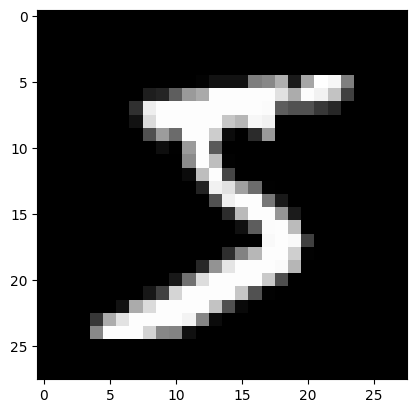

In [68]:
plt.imshow(xb[0].view(28,28))
yb[0]

Now implement a training loop with the dataloader

In [69]:
model, opt = get_model_and_optimizer()

Now create a function for the fit process since this will be used several times

In [70]:
def fit():
    for epoch in range(epochs):
        for xb, yb in train_dl:
            # Pass data through the model
            preds = model(xb)
            loss = loss_func(preds, yb)
            # Calculate gradients
            loss.backward()
            # Apply the optimiser
            opt.step()
            opt.zero_grad()
        print(f'After epoch {epoch}, batch loss is: {loss.item()}')

In [71]:
fit()

After epoch 0, batch loss is: 0.3089807331562042
After epoch 1, batch loss is: 0.19600419700145721
After epoch 2, batch loss is: 0.10103154182434082


In [72]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.17, grad_fn=<NllLossBackward0>), tensor(0.94))

In [73]:
xb.shape

torch.Size([64, 784])

### Adding in different sampling methods

To enable random or linear sampling a class is added to manage the sampling.  This will now be developed.  The inputs to the sampler need to be the dataset and a flag to indicate the type of sampling.  The return should be the same dataset either shuffled or processed as necessary.  This could be done upon just the item index values or the whole dataset could be processed and returned.  In this case the item indexies are returned as a list as requested by the iter call

I'm not sure why yield is not used here - something to check up on

In [74]:
import random

In [75]:
class Sampler():
    def __init__(self, ds, shuffle=False):
        self.n = len(ds)
        self.ds = ds
        self.shuffle = shuffle
    
    def __iter__(self):
        indecies = list(range(self.n))
        if self.shuffle:
            random.shuffle(indecies)
        return iter(indecies)

In [76]:
from itertools import islice

In [77]:
sampler = Sampler(x_train, shuffle=False)
iterator = iter(sampler)
ids = []
for i in range(5): ids.append(next(iterator))
ids

[0, 1, 2, 3, 4]

This is returning things one item at a time from the iterator.  It is possible to use islice to generate a range of items.  Note that since this iterator has already returned five entries it will supply the next 5, it doesn't start from to front of the list unless a new iterator is created

In [78]:
ids = list(islice(iterator, 0, 5))
ids

[5, 6, 7, 8, 9]

When the random flag is set to true then

In [79]:
sampler = Sampler(x_train, shuffle=True)
list(islice(sampler, 0, 10))

[19149, 3623, 33271, 45722, 34626, 44572, 33273, 31591, 1328, 44705]

In [80]:
sampler_v = Sampler(x_valid, shuffle=False)
list(islice(sampler_v, 0, 10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Having proven the basics of the sampler the fastcore library will be used to create a batch sampler. Two fastcore methods are used:
1. store_attr.  This simply saves any parameters supplied as class properties with the same name as the supplied parameter
2. chunked. This returns batches of indecies from an iterator of user defined size with the option to specity whether to drop the last chunk if not the batch size, and also to provide only a defined number of chunks (useful to use a part of a dataset when get things working)

In [81]:
import fastcore.all as fc

The class BatchSampler is require to take as input the dataset, batch size, the sampler, and whether to drop the last batch if not the correct size.  In this case the dataset is already embedded into the sampler and hence does not need to be added separately. 
The output should be an iterator returning batches of indecies

In [82]:
class BatchSampler:
    def __init__(self, sampler, bs=16, drop_last=False):
        fc.store_attr()
    
    def __iter__(self, ):
        yield from fc.chunked(iter(self.sampler), chunk_sz=self.bs, drop_last=self.drop_last)

In [83]:
batches = BatchSampler(sampler, bs=4, drop_last=False)

In [84]:
next(iter(batches))

[25976, 3805, 2452, 7221]

In [85]:
list(islice(batches, 5))

[[43889, 38760, 1660, 43812],
 [19474, 27881, 1648, 5994],
 [43292, 20760, 47927, 46678],
 [16207, 19001, 31035, 2216],
 [21505, 234, 47366, 36409]]

BatchSampler will provide a list of ids with which to make up the batch.  The Sampler will then return the individual input data and targets for each id.  The then have to collate the inputs and targets into torch arrays for processing.

This collation and stacking of data is done by a collate function

We now need a collate method to take the samples and convert them into a stacked tensor or inputs and outputs

Collator inputs: list of tuples of input value pairs
outputs: tuple of input and target values as torch tensors

In [86]:
def collate(b):
    # the * means that multiple items will be received, which effectively means the list is taken an item
    # at a time
    xb, yb = zip(*b)
    return (torch.stack(xb), torch.stack(yb))

In [87]:
bi = [train_ds[0], train_ds[1], train_ds[2]]
collate(bi)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4]))

#### Finally create a full dataloader using the above components

inputs:dataset, batch size, sampling method to use, whether to use last batch

outputs: tuple of stacked array of inputs and targets

methods: initiation - setup the dataset, sampling method, batch size, options
         iter - return a batch of data as a tuple

In [88]:
class DataLoader():
    def __init__(self, dataset, collate_fn=collate, bs=64, shuffle=False, drop_last=False):
        fc.store_attr()
        sampler = Sampler(ds=dataset, shuffle=shuffle)
        self.batch_sampler = BatchSampler(sampler, bs, drop_last)
        
    def __iter__(self):
        yield from (self.collate_fn(self.dataset[i] for i in b) for b in self.batch_sampler)

In [89]:
train_dl = DataLoader(train_ds, collate, bs=64, shuffle=True)
valid_dl = DataLoader(valid_ds, collate, bs=64, shuffle=False)

In [90]:
train_batch = next(iter(train_dl))
train_batch[0].shape, train_batch[1].shape

(torch.Size([64, 784]), torch.Size([64]))

In [91]:
xb,yb = next(iter(valid_dl))
xb.shape

torch.Size([64, 784])

tensor(3)

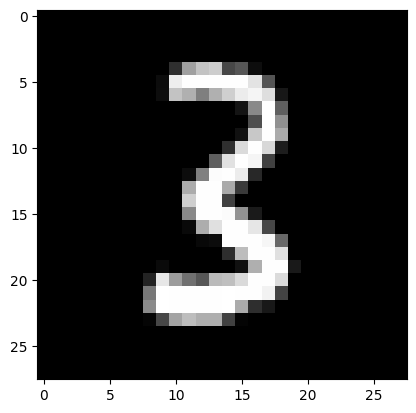

In [92]:
xb,yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [93]:
# Check the accuracy of the model when trained with the Dataloader
model,opt = get_model_and_optimizer()
fit()

loss_func(model(xb), yb), accuracy(model(xb), yb)

After epoch 0, batch loss is: 0.05507710948586464
After epoch 1, batch loss is: 0.055910542607307434
After epoch 2, batch loss is: 0.07595346868038177


(tensor(0.10, grad_fn=<NllLossBackward0>), tensor(0.97))

### Multiprocesssing DataLoader
Data loading is often a constraint in terms or time to process a job.  Fortunately this is a task that lends itself to multi-processing and hence it makes sense to apply this.

Pytorch provide a multi-processing library and that is what will be used here.

The way it will be done is that the above library will provide a pool or workers, the number of which can be defined.  Each worker can then be asked to load a batch of data.  The batches returned will be returned as requested

In [94]:
import torch.multiprocessing as mp
from fastcore.basics import store_attr

The way a dataset returns values based upon the index uses the getitem dunder as can be seen here

In [95]:
train_ds.__getitem__([[3,5,8,10]])

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 2, 1, 3]))

In [96]:
train_ds.__getitem__([3,5,8,10])

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 2, 1, 3]))

It is possible to use the map function to split individual groups of items as below

In [97]:
for o in map(train_ds.__getitem__, [[3,5], [8,10]]):
    print(o)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 2]))
(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 3]))


The dataloader can then be modified so that each worker in a pool loads a batch and return it when requested.  Note that it appears that the collate function is not needed here since the way in which the batch sampler passes a list of indecies results in an array of values being returned.

In [98]:
class DataLoader():
    def __init__(self, dataset, bs=64, shuffle=False, drop_last=False, num_workers=1):
        fc.store_attr()
        sampler = Sampler(ds=dataset, shuffle=shuffle)
        self.batch_sampler = BatchSampler(sampler, bs, drop_last)
        
    def __iter__(self):
        with mp.Pool(self.num_workers) as ex:
            yield from ex.map(self.dataset.__getitem__, iter(self.batch_sampler))

In [99]:
train_dl = DataLoader(train_ds, bs=64, shuffle=True, num_workers=2)

In [100]:
it = iter(train_dl)
res = next(it)

In [101]:
xb, yb = next(it)
xb.shape, yb.shape

(torch.Size([64, 784]), torch.Size([64]))

In [102]:
len(res),res[0].shape

(2, torch.Size([64, 784]))

### Pytorch DataLoader 

Steps to follow:
1. Create batch sampler
2. create dataloader (with multi worker)
3. Train model entirely using PyTorch
4. 

In [104]:
train_bs = BatchSampler(RandomSampler(train_ds), batch_size=bs, drop_last=False)
valid_bs = BatchSampler(SequentialSampler(valid_ds), batch_size=bs, drop_last=False)

In [105]:
# In this case the collate function is not required
train_dl = DataLoader(train_ds, batch_sampler=train_bs, num_workers=4, collate_fn=collate)
valid_dl = DataLoader(valid_ds, batch_sampler=valid_bs, num_workers=4)

In this case the collate function is not necessary as the dataset will already do this, as was shown above by the way a list of items returns stacked arrays.  Allowing Pytorch to autogenerate teh samplers as well then this can all be simplified to

In [106]:
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, drop_last=True, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False, drop_last=False, num_workers=4)

Check accuracy as usual

In [107]:
model,opt = get_model_and_optimizer()
fit()

loss_func(model(xb), yb), accuracy(model(xb), yb)

After epoch 0, batch loss is: 0.3000752925872803
After epoch 1, batch loss is: 0.034155331552028656
After epoch 2, batch loss is: 0.07146771252155304


(tensor(0.12, grad_fn=<NllLossBackward0>), tensor(0.97))

### Validation

It is good (essential) practice to have a validation set and to check the accuracu of the model periodically, such as at the end of each epoch.

Before calling the validation dataset it is necessary to put the model into eval mode, which avoids issues with batchnorm and dropout layers, where different setting are used for training

Create an update fit routine which calculates and prints out loss and accuracy at the end of each epoch.  As input define the number of epochs, the model to use, the loss function, the optimiser and the train and test dataloasers

In [3]:
#| echo: false
#| output: asis
show_doc(fit)

---

[source](https://github.com/fastai/fastai-course-22p/blob/master/miniai/training.py#L26){target="_blank" style="float:right; font-size:smaller"}

### fit

>      fit (epochs, model, loss_func, opt, train_dl, valid_dl)

In [109]:
model,opt = get_model_and_optimizer()

In [110]:
fit(epochs=3, model=model, loss_func=loss_func, opt=opt, train_dl=train_dl, valid_dl=valid_dl)

Epoch: 0, loss: 0.16384194791316986, acc: 0.9517999887466431
Epoch: 1, loss: 0.11577688157558441, acc: 0.963699996471405
Epoch: 2, loss: 0.11353033781051636, acc: 0.9666000008583069


Finally create the dataloader using a function and then simplify the whole training process to three lines

In [111]:
def get_data_loaderers(train_ds, valid_ds, bs):
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
    valid_ds = DataLoader(valid_ds, batch_size=bs, shuffle=False)
    return train_dl, valid_dl

In [112]:
model, opt = get_model_and_optimizer()
train_dl, valid_dl = get_data_loaderers(train_ds, valid_ds, bs=bs)
fit(epochs=3, model=model, loss_func=loss_func, opt=opt, train_dl=train_dl, valid_dl=valid_dl)

Epoch: 0, loss: 0.20603491365909576, acc: 0.9343000054359436
Epoch: 1, loss: 0.20518435537815094, acc: 0.9363999962806702
Epoch: 2, loss: 0.1369418054819107, acc: 0.9598000049591064


## Export

In [ ]:
import nbdev; nbdev.nbdev_export()